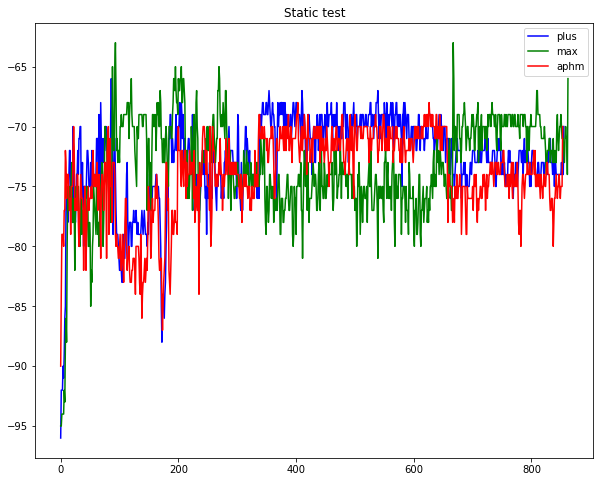

In [215]:
# Beacon RSSI at fixed distance
wb = openpyxl.load_workbook('beacon2.xlsx')
sheet = wb.get_sheet_by_name('Sheet0')

dataNum = 4967

beacon_data2 = [entry() for i in range(dataNum)]

for i in range(1,dataNum):
    beacon_data2[i].id = sheet.cell(row=i+1,column=1).value
    beacon_data2[i].user_id = sheet.cell(row=i+1,column=2).value
    beacon_data2[i].rssi = sheet.cell(row=i+1,column=9).value
    beacon_data2[i].major = int(sheet.cell(row=i+1,column=14).value)
    beacon_data2[i].minor = int(sheet.cell(row=i+1,column=15).value)
    beacon_data2[i].date = sheet.cell(row=i+1,column=23).value    
    dateStr = sheet.cell(row=i+1,column=22).value
    d1 = dateStr.split(" ")
    time1 = d1[1].split(":")
    time2 = time1[2].split(".")
    beacon_data2[i].svrHour = int(time1[0])
    beacon_data2[i].svrMnut = int(time1[1])
    beacon_data2[i].svrScnd = int(time2[0])

plusShu = []
maxShu = []
aphmShu = []

for i in range(1,dataNum):
    if beacon_data2[i].minor == 11:
        plusShu.append(beacon_data2[i].rssi)
    if beacon_data2[i].minor == 4:
        maxShu.append(beacon_data2[i].rssi)
    if beacon_data2[i].minor == 15:
        aphmShu.append(beacon_data2[i].rssi)
        
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.plot(plusShu,'b-', label='plus')
plt.plot(maxShu,'g-', label='max')
plt.plot(aphmShu,'r-', label='aphm')
plt.title("Static test")
plt.legend()
plt.show()

In [220]:
# Here we process the beacon data
# First we test reading the excel file
import openpyxl
wb = openpyxl.load_workbook('beacon1.xlsx')
sheet = wb.get_sheet_by_name('Sheet0')

In [281]:
class entry():
    def __inf__(self):
        self.id = None
        self.user_id = None
        self.rssi = None
        self.major = None
        self.minor = None
        self.date = None
        self.svrHour = None
        self.svrMnut = None
        self.svrScnd = None

import numpy as np
def calculateAccuracy(txPower, rssi):
    if rssi < -99:
        return 50.0 # if we cannot determine accuracy, return -1.
    ratio = rssi*1.0/txPower
    if ratio < 1.0:
        return np.power(ratio,10)
    else:
        accuracy =  (0.89976)*np.power(ratio,7.7095) + 0.111; 
    return accuracy

def calculateWindowVar(rssi,windSize):
    length = len(rssi)
    rssi = np.array(rssi)
    varLen = length-windSize
    varVec = [0 for i in range(0,varLen)]
    for i in range(0,varLen):
        window = rssi[i:i+windSize]
        varVec[i] = np.var(window)
    return varVec

# Binary signal x is filtered
# Ones lasts less than n times are considered as noise
# Noise are removed
def windowFilter(y,n):
    x = [i for i in y]
    headPos = 0;
    tailPos = 0
    lastNbr = 0;
    for currPos in range(0,len(x)):
        if lastNbr == 0 and x[currPos] == 1:
            headPos = currPos
            if currPos - tailPos < n and headPos <= tailPos:
                for i in range(tailPos,currPos):
                    x[i] = 1
        if lastNbr == 1 and x[currPos] == 0:
            tailPos = currPos
            if currPos - headPos < n and headPos <= tailPos:
                for i in range(headPos,currPos):
                    x[i] = 0
        lastNbr = x[currPos]
    return x
            
        

In [238]:
import numpy as np

dataNum = 14658

beacon_data = [entry() for i in range(dataNum)]

for i in range(1,dataNum):
    beacon_data[i].id = sheet.cell(row=i+1,column=1).value
    beacon_data[i].user_id = sheet.cell(row=i+1,column=2).value
    beacon_data[i].rssi = sheet.cell(row=i+1,column=9).value
    beacon_data[i].major = int(sheet.cell(row=i+1,column=14).value)
    beacon_data[i].minor = int(sheet.cell(row=i+1,column=15).value)
    beacon_data[i].date = sheet.cell(row=i+1,column=23).value    
    dateStr = sheet.cell(row=i+1,column=22).value
    d1 = dateStr.split(" ")
    time1 = d1[1].split(":")
    time2 = time1[2].split(".")
    beacon_data[i].svrHour = int(time1[0])
    beacon_data[i].svrMnut = int(time1[1])
    beacon_data[i].svrScnd = int(time2[0])
    

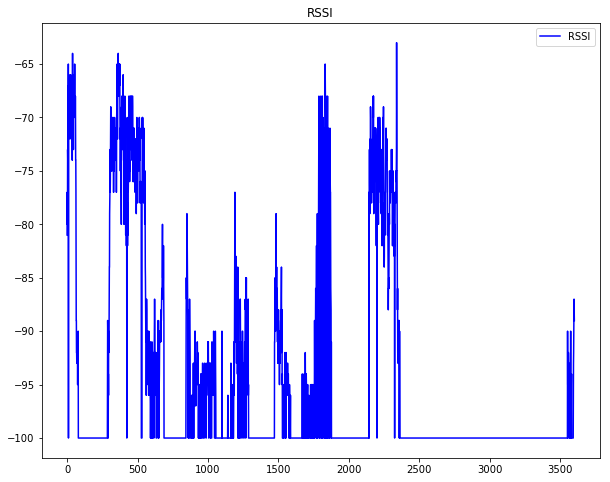

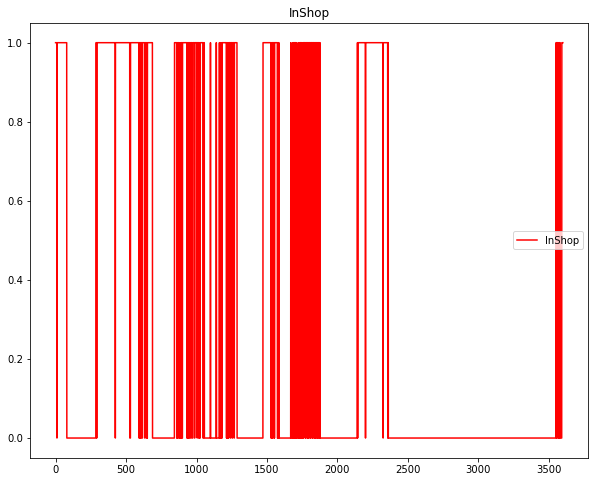

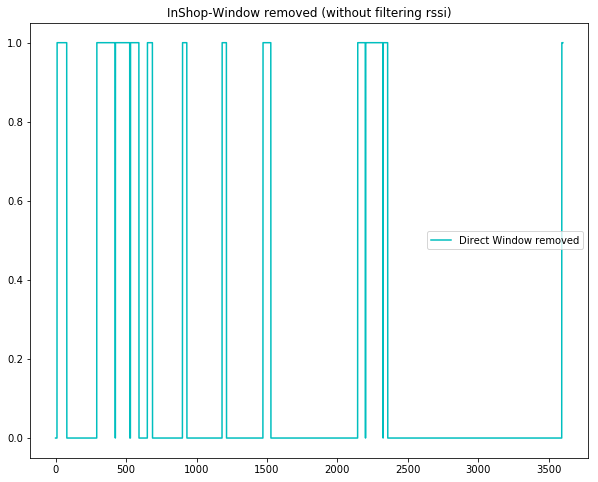

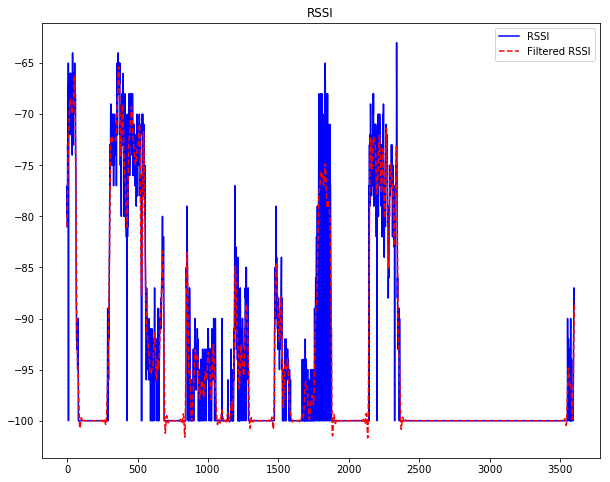

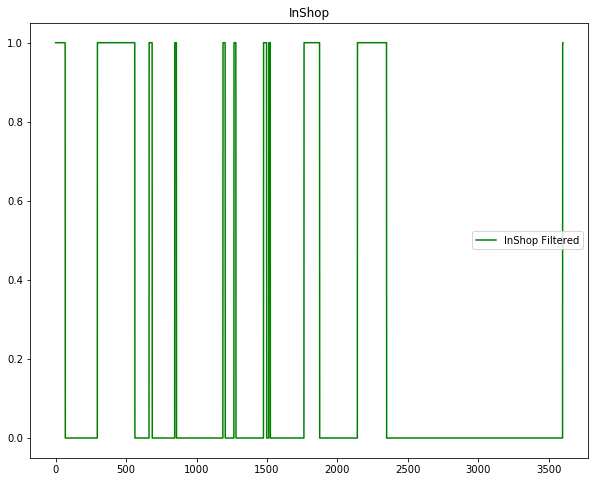

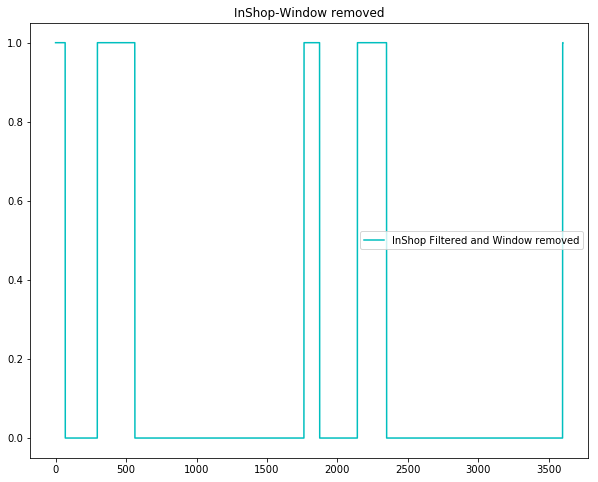

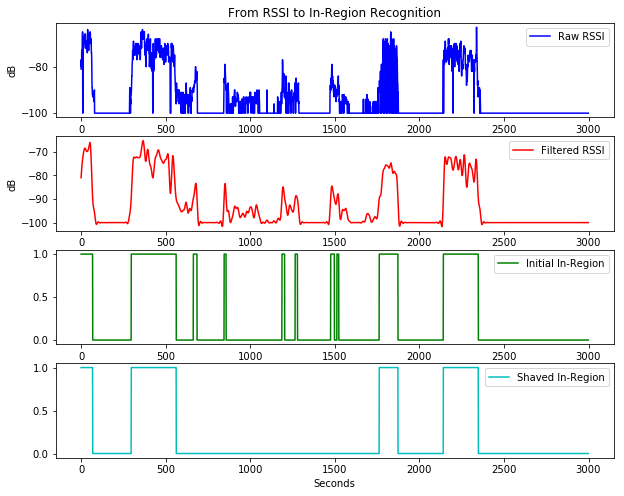

In [283]:
# Plot the RSSI data and InShop Data
totalTimeStep = 3600
HaoDaDaRSSI = [-100 for i in range(totalTimeStep)]
HaoDaDaInShop = [0 for i in range(totalTimeStep)]
for i in range(0,len(timeStamp)):
    timeStamp[i] = i
for i in range (1,dataNum):
    if beacon_data[i].minor == 1:
        timeStep = beacon_data[i].svrMnut*60+beacon_data[i].svrScnd
        if HaoDaDaRSSI[timeStep] != -100:
            #print("GET TWO SIGNAL IN ONE SECOND?! at: ",timeStep)
            if beacon_data[i].rssi < HaoDaDaRSSI[timeStep]:
                continue
        HaoDaDaRSSI[timeStep] = beacon_data[i].rssi
        HaoDaDaInShop[timeStep] = 1

plt.clf()
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.plot(HaoDaDaRSSI,'b-',label='RSSI')
plt.title('RSSI')
plt.legend()
plt.show()
plt.clf()

fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.plot(HaoDaDaInShop,'r-',label='InShop')
plt.title('InShop')
plt.legend()
plt.show()
plt.clf()


df = windowFilter(HaoDaDaInShop,30)
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.plot(df,'c-',label='Direct Window removed')
plt.title('InShop-Window removed (without filtering rssi)')
plt.legend()
plt.show()
plt.clf()

from scipy import signal
fs = 1
nyq = 0.5 * fs
wn = 0.05 / nyq
order = 6
b, a = signal.butter(order, wn, 'low',analog = False)

# plt.figure(1)
# plt.clf()
# for order in [3, 6, 9]:
#     b, a = signal.butter(order, wn, 'low',analog = False)
#     w, h = freqz(b, a, worN=2000)
#     plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

# plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],'--', label='sqrt(0.5)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Gain')
# plt.grid(True)
# plt.legend(loc='best')
# plt.show()

y = signal.filtfilt(b, a, HaoDaDaRSSI)

plt.clf()
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.plot(HaoDaDaRSSI,'b-',label='RSSI')
plt.plot(y,'r--',label='Filtered RSSI')
plt.title('RSSI')
plt.legend()
plt.show()
plt.clf()

filterInShop = [0 for i in range(0,len(y))]
for i in range(0,len(y)):
    if y[i] > -90:
        filterInShop[i] = 1

fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.plot(filterInShop,'g-',label='InShop Filtered')
plt.title('InShop')
plt.legend()
plt.show()
plt.clf()

z = windowFilter(filterInShop,60)
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.plot(z,'c-',label='InShop Filtered and Window removed')
plt.title('InShop-Window removed')
plt.legend()
plt.show()
plt.clf()

# np.set_printoptions(threshold=np.nan)
# print("rssi:",HaoDaDaRSSI)
# print("y:,",np.array(y))

# w, h = signal.freqs(b, a)
# plt.semilogx(w, 20 * np.log10(abs(h)))
# plt.title('Butterworth filter frequency response')
# plt.xlabel('Frequency')
# plt.ylabel('Amplitude [dB]')
# plt.margins(0, 0.1)
# plt.grid(which='both', axis='both')
# plt.axvline(100, color='green') # cutoff frequency
# plt.show()


plotEnd = 3000           # If we only want to plot partial data
plt.clf()    
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.subplot(4,1,1)
plt.plot(HaoDaDaRSSI[0:plotEnd],'b-',label = "Raw RSSI")
plt.legend()
plt.ylabel("dB")
plt.title("From RSSI to In-Region Recognition")
plt.subplot(4,1,2)
plt.plot(y[0:plotEnd],'r-',label = "Filtered RSSI")
plt.legend()
plt.ylabel("dB")
plt.subplot(4,1,3)
plt.plot(filterInShop[0:plotEnd],'g-',label = "Initial In-Region")
plt.legend()
plt.subplot(4,1,4)
plt.plot(z[0:plotEnd],'c-',label = "Shaved In-Region")
plt.legend()
plt.xlabel("Seconds")
plt.show()


In [229]:
totalTimeStep = 60*60

w, h = 18, totalTimeStep;
BeaconRssi = [[-100 for x in range(0,w)] for y in range(0,h)]

hour = 15

for i in range(0,dataNum):
    timeStep = beacon_data[i].svrMnut*60+beacon_data[i].svrScnd
    BeaconRssi[timeStep][beacon_data[i].minor-1] = beacon_data[i].rssi
        
# Calculate the accuracy
w, h = 18, totalTimeStep;
AccuMat = [[0 for x in range(0,w)] for y in range(0,h)]
for timeStep in range(0,totalTimeStep):
    for bcid in range(0,18):
        if bcid == 6 or (bcid < 12 and bcid > 7):
            AccuMat[timeStep][bcid] = calculateAccuracy(-59, BeaconRssi[timeStep][bcid])
        else:
            AccuMat[timeStep][bcid] = calculateAccuracy(-65, BeaconRssi[timeStep][bcid])
            
        
import matplotlib.pyplot as plt


windSize = 50
# HaoDaDa
HaoDaDaRssi = [row[0] for row in BeaconRssi]
HaoDaDaAccu = [row[0] for row in AccuMat]
HaoDaDaRssiVar = calculateWindowVar(HaoDaDaRssi,windSize)

fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.plot(HaoDaDaAccu)
plt.title("HaoDaDaAccu")
plt.show()


fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.plot(HaoDaDaRssiVar)
plt.title("HaoDaDaRssiVar")
plt.show()


# Here we try to analyze the HaoDaDa 


AttributeError: 'entry' object has no attribute 'svrMnut'

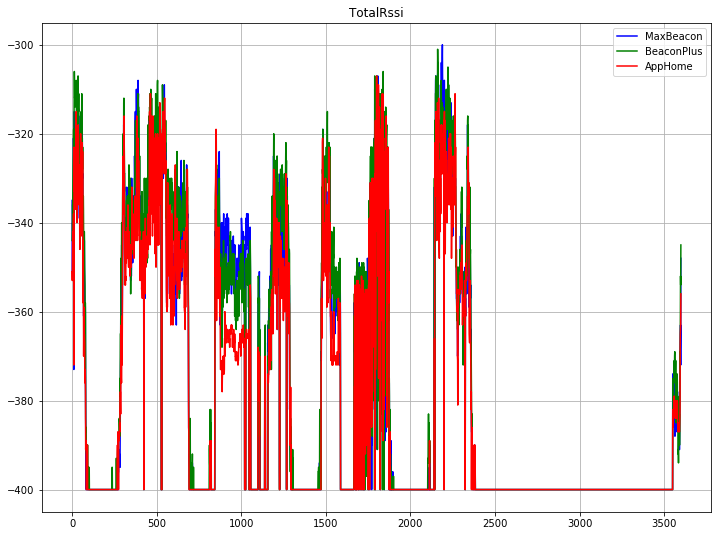

diff1Avg: 1.885212694125591
diff2Avg: 2.435055865921788


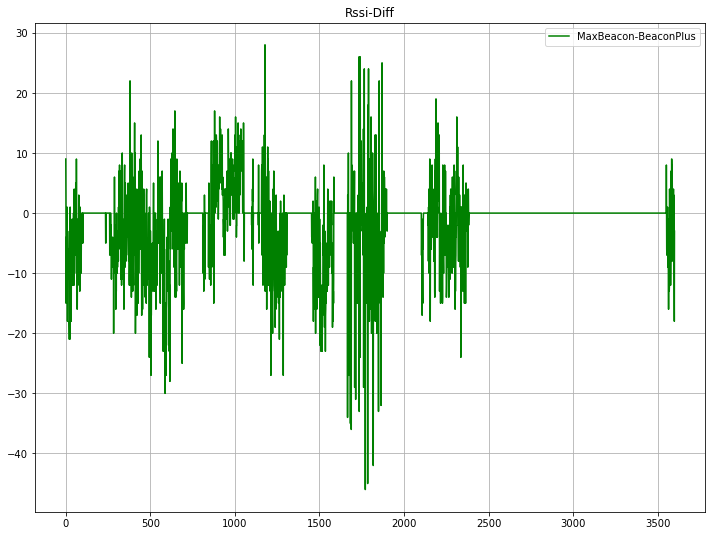

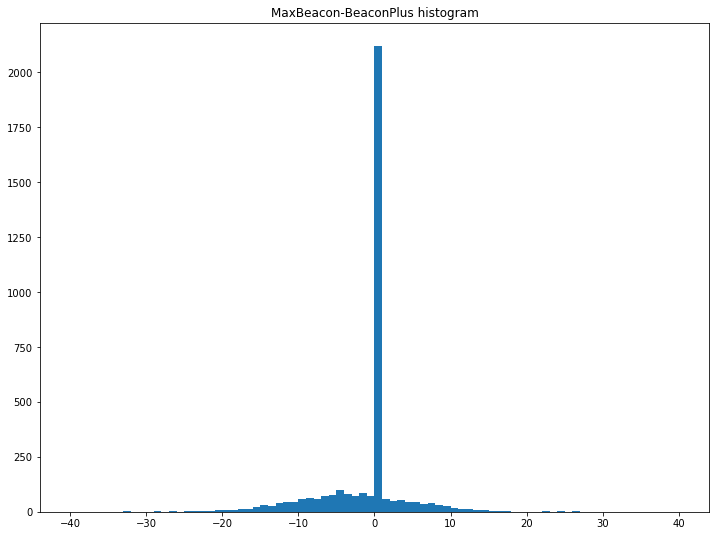

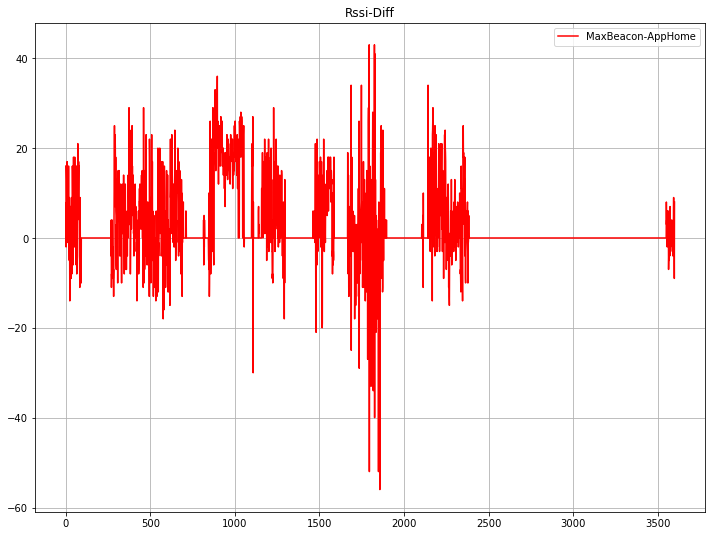

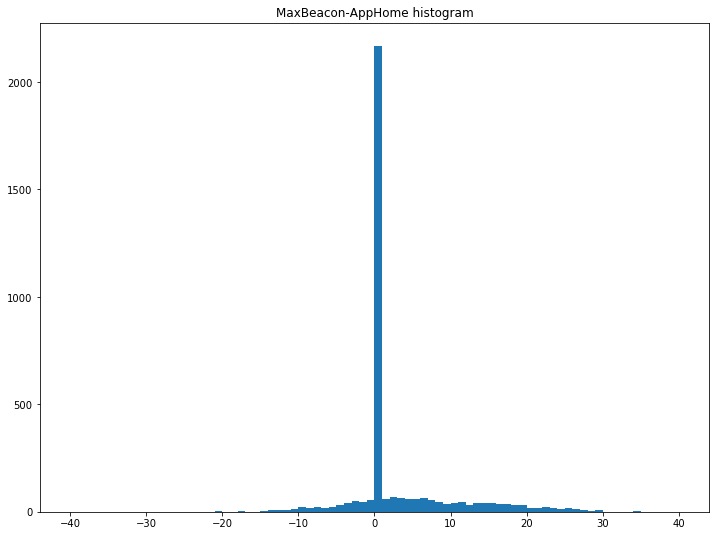

Max Better than Plus:  0.128 Worse than Plus:  0.283 Same:  0.589
Max Better than Aphm:  0.288 Worse than Aphm:  0.109 Same:  0.602


In [219]:
MaxBeaconTotalRssi = [None for i in range(3600)]
BeaconPlusTotalRssi = [None for i in range(3600)]
AppHomeTotalRssi = [None for i in range(3600)]


# Plot Signal Difference
for i in range(3600):
    MaxBeaconTotalRssi[i] = BeaconRssi[i][0] + BeaconRssi[i][1] + BeaconRssi[i][2] + BeaconRssi[i][3];
    BeaconPlusTotalRssi[i] = BeaconRssi[i][7] + BeaconRssi[i][8] + BeaconRssi[i][9] + BeaconRssi[i][10];
    AppHomeTotalRssi[i] = BeaconRssi[i][11] + BeaconRssi[i][12] + BeaconRssi[i][13] + BeaconRssi[i][14];

fig = plt.gcf()
fig.set_size_inches(12, 9)
plt.plot(MaxBeaconTotalRssi,'b-', label='MaxBeacon')
plt.plot(BeaconPlusTotalRssi,'g-', label='BeaconPlus')
plt.plot(AppHomeTotalRssi,'r-', label='AppHome')
plt.title("TotalRssi")
plt.grid()
plt.legend()
plt.show()
plt.clf()



diff1 = [None for i in range(3600)];
diff2 = [None for i in range(3600)];
for i in range(3600):
    diff1[i] = MaxBeaconTotalRssi[i] - BeaconPlusTotalRssi[i];
    diff2[i] = MaxBeaconTotalRssi[i] - AppHomeTotalRssi[i];

diff1abs = [abs(number) for number in diff1]
diff2abs = [abs(number) for number in diff2]
diff1Avg = sum(diff1abs)/(sum(i > 0 for i in diff1abs)*4)
diff2Avg = sum(diff2abs)/(sum(i > 0 for i in diff2abs)*4)
    
print("diff1Avg:",diff1Avg)
print("diff2Avg:",diff2Avg)
    
bins = np.linspace(-40, 40, 81)
    
fig = plt.gcf()
fig.set_size_inches(12, 9)
plt.plot(diff1,'g-', label='MaxBeacon-BeaconPlus')
plt.title("Rssi-Diff")
plt.grid()
plt.legend()
plt.show()
plt.clf()

fig = plt.gcf()
fig.set_size_inches(12, 9)
plt.hist(diff1,bins)
plt.title("MaxBeacon-BeaconPlus histogram")
plt.show()

fig = plt.gcf()
fig.set_size_inches(12, 9)
plt.plot(diff2,'r-', label='MaxBeacon-AppHome')
plt.title("Rssi-Diff")
plt.grid()
plt.legend()
plt.show()
plt.clf()


fig = plt.gcf()
fig.set_size_inches(12, 9)
plt.hist(diff2,bins)
plt.title("MaxBeacon-AppHome histogram")
plt.show()

ratioDiff1Btr = sum(i > 0 for i in diff1)/3600
ratioDiff1Les = sum(i < 0 for i in diff1)/3600
ratioDiff1Eql = sum(i == 0 for i in diff1)/3600

ratioDiff2Btr = sum(i > 0 for i in diff2)/3600
ratioDiff2Les = sum(i < 0 for i in diff2)/3600
ratioDiff2Eql = sum(i == 0 for i in diff2)/3600

print("Max Better than Plus: ",round(ratioDiff1Btr,3),"Worse than Plus: ",round(ratioDiff1Les,3), "Same: ",round(ratioDiff1Eql,3))
print("Max Better than Aphm: ",round(ratioDiff2Btr,3),"Worse than Aphm: ",round(ratioDiff2Les,3), "Same: ",round(ratioDiff2Eql,3))

In [91]:
totalTimeStep = 60*60

w, h = 18, totalTimeStep;
BeaconRssi = [[-100 for x in range(0,w)] for y in range(0,h)]
numrows = len(BeaconRssi)    # 3 rows in your example
numcols = len(BeaconRssi[0]) # 2 columns in your example
print(numrows, numcols)
print(BeaconRssi[2][2]) 

3600 18
-100


In [111]:
rssi = [1,2,9,4,5,3,7,8,9]
windSize = 3
calculateWindowVar(rssi,windSize)

[12.666666666666666,
 8.6666666666666661,
 4.666666666666667,
 0.66666666666666663,
 2.6666666666666665,
 4.666666666666667]

In [169]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    print("normal_cutoff",normal_cutoff)
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 3
fs = 1.0       # sample rate, Hz
cutoff = 0.05  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

## Plot the frequency response.
#w, h = freqz(b, a, worN=8000)
#plt.subplot(2, 1, 1)
#plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
#plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
#plt.axvline(cutoff, color='k')
#plt.xlim(0, 0.5*fs)
#plt.title("Lowpass Filter Frequency Response")
#plt.xlabel('Frequency [Hz]')
#plt.grid()

# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 3600.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
# data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)
data = [row[17] for row in BeaconRssi];
title = "FengShouBtagKitchen"

print(data)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

#plt.subplot(2, 1, 2)
fig = plt.gcf()
fig.set_size_inches(14, 10)
plt.plot(t[10:3600], data[10:3600], 'b-', label='data')
plt.plot(t[10:3600], y[10:3600], 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.title(title)
plt.grid()
plt.legend()

plt.plot(hspace=0.35)
#plt.show()
#plt.savefig(title)
plt.clf()

normal_cutoff 0.1
[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -10